In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from scipy.stats import multivariate_normal as mvn
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture

**1-Entrenamiento**

Carga de los datos de entrenamiento 

In [4]:
x_train = pd.read_csv('practica_X_train.csv', sep=';', index_col=0)
y_train = pd.read_csv('practica_Y_train.csv', sep=';', index_col=0)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos
print("Tamaño x_train:", x_train.shape)
print("Tamaño x_test:", x_val.shape)

print(x_train.head())
print(y_train.head())

#recomendado hacer k_fold para conjunto de entrenamiento y validacion

Tamaño x_train: (3200, 9)
Tamaño x_test: (800, 9)
      Temperature  Humidity  PM2.5  PM10  NO2  SO2   CO  \
2386          5.0       6.0    3.0   4.0  6.0  4.0  5.0   
4737          2.0       2.0    0.0   1.0  3.0  1.0  0.0   
1153          2.0       2.0    0.0   0.0  3.0  2.0  1.0   
3840          5.0       5.0    0.0   1.0  4.0  1.0  7.0   
4229          3.0       3.0    0.0   1.0  5.0  4.0  4.0   

      Proximity_to_Industrial_Areas  Population_Density  
2386                            1.0                 5.0  
4737                            3.0                 4.0  
1153                            3.0                 2.0  
3840                            2.0                 4.0  
4229                            3.0                 2.0  
     Air_Quality
2386   Hazardous
4737        Good
1153        Good
3840        Poor
4229        Poor


1.1 Preprocesado ejemplos

Como el conjunto de datos x_train son datos continuos y en el enunciado se nos dice que no tenemos valores perdidos y en los modelos de Naive Bayes, MVN y GMM los datos de tipo continuo son buenas entradas. 

Por lo tanto, el único preprocesado que sería necesario para poder trabajar con el conjunto de test es codificar el atributo categórico del conjunto de y_train y aplicar un filtrado por varianza al conjunto de datos de x_train para descartar aquellas columnas que no aporten información. 

In [5]:
#filtrado por varianza conjunto x_train
thereshold = 0.1

sel = VarianceThreshold(threshold=thereshold)
sel.set_output(transform='pandas')
x_train = sel.fit_transform(x_train)

In [6]:
#codificación conjunto y_train
categoria = y_train['Air_Quality'].unique()
categoria_codificada ={string:i for i,string in enumerate(categoria)} #diccionario de codificación
cat = y_train['Air_Quality'].map(categoria_codificada)

y_train['Air_Quality'] = cat
print(y_train.head())

      Air_Quality
2386            0
4737            1
1153            1
3840            2
4229            2


1.2 Construcción modelo a priori de la etiqueta (cada nivel de calidad del aire tiene un número difernte de ejemplos)

In [7]:
clases = y_train['Air_Quality'].value_counts()  # Cantidad de todas las soluciones distintas
Probs_priori = clases / len(y_train)
print("Probabilidades a priori: ")
print(Probs_priori)

Probabilidades a priori: 
Air_Quality
1    0.399375
3    0.296563
2    0.206250
0    0.097812
Name: count, dtype: float64


1.3 Construir distintos modelos de verosimilitud

Naive Bayes 

Primer modelo posible con GaussianNB

In [8]:
naive_bayes_gaussian = GaussianNB()
naive_bayes_gaussian.fit(x_train, y_train.values.ravel()) # con y_train.values.ravel() 
                                                 # cambiamos de lista pandas a numpy
                                                 # Es para que solo nos den los valores 
                                                 # Sino te da un enlace raro tambien
print("Probabilidades a priori con Naive Bayes Gassiano:") 
print(naive_bayes_gaussian.class_prior_) # Solo para comprobar las probabilidades de las clases

predicciones_g = naive_bayes_gaussian.predict(x_train)
cont = 0
for y_hat, y_true in zip(predicciones_g, y_train.values.ravel()):
    if (y_true == y_hat):
        cont += 1
print("acc con conjunto train:", cont / len(predicciones_g))


Probabilidades a priori con Naive Bayes Gassiano:
[0.0978125 0.399375  0.20625   0.2965625]
acc con conjunto train: 0.9178125


Segundo modelo posible con CategoricalNB

In [9]:
naive_bayes_categorical = CategoricalNB()
naive_bayes_categorical.fit(x_train, y_train.values.ravel())

predicciones_c = naive_bayes_categorical.predict(x_train)
cont = 0
for y_hat, y_true in zip(predicciones_c, y_train.values.ravel()):
    if (y_true == y_hat):
        cont += 1
        
print("acc con conjunto train:", cont / len(predicciones_c))

acc con conjunto train: 0.94875


Tercer modelo posible BernoulliNB

In [10]:
naive_bayes_bernoulli = BernoulliNB(alpha= 1)
naive_bayes_bernoulli.fit(x_train, y_train.values.ravel())

predicciones_b = naive_bayes_bernoulli.predict(x_train)
cont = 0
for y_hat, y_true in zip(predicciones_b, y_train.values.ravel()):
    if (y_true == y_hat):
        cont += 1
print("acc con conjunto train:", cont / len(predicciones_b))

acc con conjunto train: 0.626875


MVN

In [11]:
def train_mvn(Y_TRAIN, X_TRAIN):
    estadisticas_modelo = {}
    clases = np.unique(Y_TRAIN)
    for clase in clases:
        datos_clase = X_TRAIN[Y_TRAIN == clase]

        media = np.mean(datos_clase, axis=0)
        covarianza = np.cov(datos_clase, rowvar=False)
        covarianza += np.eye(covarianza.shape[0]) * 1e-6

        modelo = mvn(mean=media, cov=covarianza)

        estadisticas_modelo[clase] = {"media": media, "covarianza": covarianza, "modelo": modelo}
    return estadisticas_modelo

def predict_mvn(x_a_predecir, estadisticas):
    # Predecimos probabilidades primero
    probs = []
    clases = list(estadisticas.keys())
    for clase in clases:
        modelo = estadisticas[clase]["modelo"]
        p = modelo.logpdf(x_a_predecir)
        probs.append(p)
    probs = np.array(probs).T
    y_hat = np.argmax(probs, axis=1)
    return np.array(clases)[y_hat]
    

In [12]:
y_train_flat = y_train.values.ravel()

estadisticas_MVN = train_mvn(y_train_flat, x_train.values)

y_hat = predict_mvn(x_train.values, estadisticas_MVN)
acc = np.mean(y_hat == y_train_flat)
print("acc con conjunto train: ", acc)

acc con conjunto train:  0.924375


GMM

In [13]:
# Calcular las medias de cada clase
means_class_0 = x_train[y_train_flat == 0].mean(axis=0).values.reshape(1, -1)
means_class_1 = x_train[y_train_flat == 1].mean(axis=0).values.reshape(1, -1)

# Iniciar los parámetros de los modelos GMM con las medias de cada clase
means_init_0 = np.tile(means_class_0, (4, 1))
means_init_1 = np.tile(means_class_1, (4, 1))

# Entrenar el modelo GMM para cada clase
gmm0 = GaussianMixture(n_components=4, means_init=means_init_0, covariance_type='diag', max_iter=10)
gmm0.fit(x_train[y_train_flat == 0])

gmm1 = GaussianMixture(n_components=4, means_init=means_init_1, covariance_type='diag', max_iter=10)
gmm1.fit(x_train[y_train_flat == 1])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GaussianMixture(covariance_type='diag', max_iter=10,
                means_init=array([[2.11658842, 2.08841941, 0.1314554 , 0.18309859, 1.60172144,
        1.69953052, 0.66353678, 3.6885759 , 2.26995305],
       [2.11658842, 2.08841941, 0.1314554 , 0.18309859, 1.60172144,
        1.69953052, 0.66353678, 3.6885759 , 2.26995305],
       [2.11658842, 2.08841941, 0.1314554 , 0.18309859, 1.60172144,
        1.69953052, 0.66353678, 3.6885759 , 2.26995305],
       [2.11658842, 2.08841941, 0.1314554 , 0.18309859, 1.60172144,
        1.69953052, 0.66353678, 3.6885759 , 2.26995305]]),
                n_components=4)

In [14]:
#Ver lo bueno que es el GMM, ver el ajuste por cada clase 
log_likelihood = gmm0.score(x_train)
print("Log-Verosimilitud clase 0: ", log_likelihood)

log_likelihood = gmm1.score(x_train)
print("Log-Verosimilitud clase 1: ", log_likelihood)

Log-Verosimilitud clase 0:  -27.38289907858294
Log-Verosimilitud clase 1:  -31.228826852742277


1.4 Construir sistemas con preprocesado, modelo a priori y cada uno de los modelos de verosimilitud

Sistema con Naive Bayes 

In [15]:
def sistema_naive_bayes_categorical(x_train, y_train):
    # Preprocesado: Filtrado por varianza
    threshold = 0.1
    sel = VarianceThreshold(threshold=threshold)
    sel.set_output(transform='pandas')
    x_train_preprocessed = sel.fit_transform(x_train)

    # Codificación de y_train
    categorias = y_train['Air_Quality'].unique()
    categoria_codificada = {string: i for i, string in enumerate(categorias)}
    y_train_codificado = y_train['Air_Quality'].map(categoria_codificada)

    # Modelo a priori
    clases = y_train_codificado.value_counts()
    probs_priori = clases / len(y_train_codificado)
    print("Probabilidades a priori:")
    print(probs_priori)

    # Entrenamiento del modelo Naive Bayes con CategoricalNB
    naive_bayes_categorical.fit(x_train_preprocessed, y_train_codificado)

    # Predicción y evaluación
    predicciones = naive_bayes_categorical.predict(x_train_preprocessed)
    acc = np.mean(predicciones == y_train_codificado)
    print("Accuracy con conjunto train:", acc)

    return naive_bayes_categorical, sel, categoria_codificada

# Llamar al sistema
modelo, selector_varianza, codificacion_categorias = sistema_naive_bayes_categorical(x_train, y_train)

Probabilidades a priori:
Air_Quality
1    0.399375
3    0.296563
2    0.206250
0    0.097812
Name: count, dtype: float64
Accuracy con conjunto train: 0.94875


Sistema con MVN

In [16]:
def sistema_mvn(x_train, y_train):
    # Preprocesado: Filtrado por varianza
    threshold = 0.1
    sel = VarianceThreshold(threshold=threshold)
    sel.set_output(transform='pandas')
    x_train_preprocessed = sel.fit_transform(x_train)

    # Codificación de y_train
    categorias = y_train['Air_Quality'].unique()
    categoria_codificada = {string: i for i, string in enumerate(categorias)}
    y_train_codificado = y_train['Air_Quality'].map(categoria_codificada)

    # Modelo a priori
    clases = y_train_codificado.value_counts()
    probs_priori = clases / len(y_train_codificado)
    print("Probabilidades a priori:")
    print(probs_priori)

    # Entrenamiento
    modelo_mvn = train_mvn(y_train_codificado.values, x_train_preprocessed.values)

    # Predicción y evaluación
    predicciones = predict_mvn(x_train_preprocessed.values, modelo_mvn)
    acc = np.mean(predicciones == y_train_codificado.values)
    print("Accuracy con conjunto train:", acc)

    return modelo_mvn, sel, categoria_codificada

# Llamar al sistema
modelo_mvn, selector_varianza_mvn, codificacion_categorias_mvn = sistema_mvn(x_train, y_train)



Probabilidades a priori:
Air_Quality
1    0.399375
3    0.296563
2    0.206250
0    0.097812
Name: count, dtype: float64
Accuracy con conjunto train: 0.924375


Sistema con GMM

1.5 Comparar los sistema con un conjunto de validación  (elegir uno de los sistemas)

1.6 Almacenamiento objetos con Pickle

**2-Implementación e inferencia**

Creación script inferencia

2.1 Cargar objetos guardados del sistema seleccionado

2.2 Cargar conjunto de datos de test

2.3 Ejecución objetos guardados y guardado etiquetas predichas en un CSV con el mismo formato que practica_Y_train.csv

**3-Clustering**

3.1 Realizacion de clastering sobre el conjunto de datos practica_X_train.csv

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Escalar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)


# Aplicar K-Means
n_clusters = len(y_train['Air_Quality'].unique())  # Número de clusters igual al número de clases
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(x_train_scaled)

# Relacionar clusters con etiquetas
cluster_to_label = {}
for cluster in range(n_clusters):
    mask = clusters == cluster
    most_common_label = y_train[mask]['Air_Quality'].mode()[0]
    cluster_to_label[cluster] = most_common_label

# Asignar etiquetas a los clusters
y_pred = [cluster_to_label[cluster] for cluster in clusters]

# Evaluar la precisión
accuracy = accuracy_score(y_train['Air_Quality'], y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


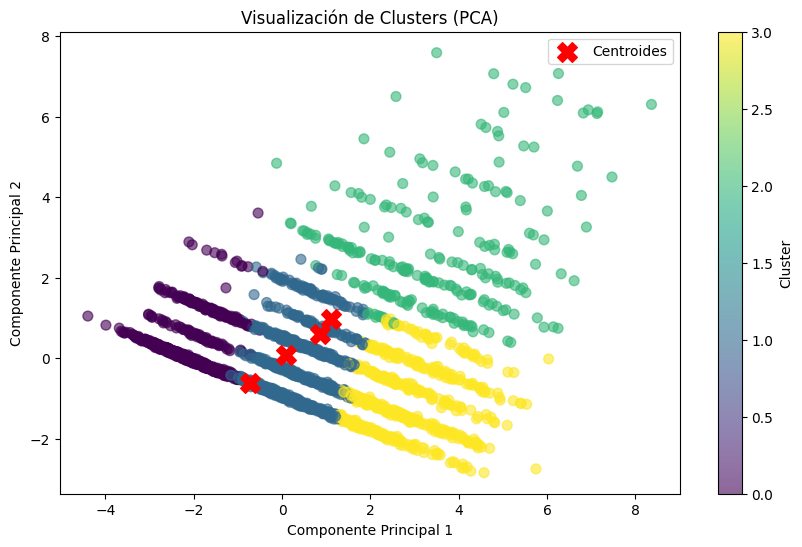

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir los datos a 2 dimensiones con PCA
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)

# Crear un scatter plot de los datos clusterizados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.colorbar(scatter, label='Cluster')
plt.title("Visualización de Clusters (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

COMO EL PROFE   

In [29]:
def inicializar_centroides_de_datos(K, X):
    indices = np.random.choice(X.shape[0], K, replace=False)
    return X[indices]

# Distancia Manhattan
def distancia_manhattan(A, B):
    return np.sum(np.abs(A - B))

# Distancia Euclídea
def distancia_euclidea(A, B):
    return np.sqrt(np.sum((A - B) ** 2))

# Calcular nuevos centroides
def calcular_nuevos_centroides(K, clusters, X):
    centroides = np.zeros((K, X.shape[1]))  # Reserva de memoria
    for idx, cluster in enumerate(clusters):
        if len(cluster) > 0:  # Evitar divisiones por cero
            nuevo_centroide = np.mean(X[cluster], axis=0)
            centroides[idx] = nuevo_centroide
    return centroides

# Crear clusters
def crear_clusters(K, X, centroides):
    clusters = [[] for _ in range(K)]
    for punto_idx, punto in enumerate(X):
        centroide_mas_cercano_idx = np.argmin(
            [distancia_euclidea(punto, centroide) for centroide in centroides]
        )
        clusters[centroide_mas_cercano_idx].append(punto_idx)
    return clusters

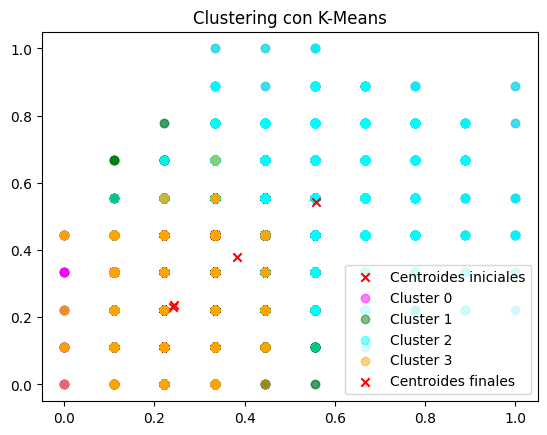

In [ ]:
import matplotlib.pyplot as plt

# Configuración inicial
seed = 42
np.random.seed(seed)
max_iters = 30
K = 4 # Número de clusters

X = x_train.values

# Inicializar centroides
centroides = inicializar_centroides_de_datos(K, X)

# Visualización inicial
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(centroides[:, 0], centroides[:, 1], color='red', marker='x', label='Centroides iniciales')

# Algoritmo de clustering
for _ in range(max_iters):
    clusters = crear_clusters(K, X, centroides)
    centroides_anteriores = centroides
    centroides = calcular_nuevos_centroides(K, clusters, X)

# Visualización final
colors = ['magenta', 'green', 'cyan', 'orange']
for k in range(K):
    cluster_points = X[clusters[k]]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[k], alpha=0.5, label=f'Cluster {k}')
plt.scatter(centroides[:, 0], centroides[:, 1], color='red', marker='x', label='Centroides finales')
plt.legend()
plt.title("Clustering con K-Means")
plt.show()

3.2.1 ¿Cuantos clusters has elegido?¿Elección relacionada con el número de clases? 

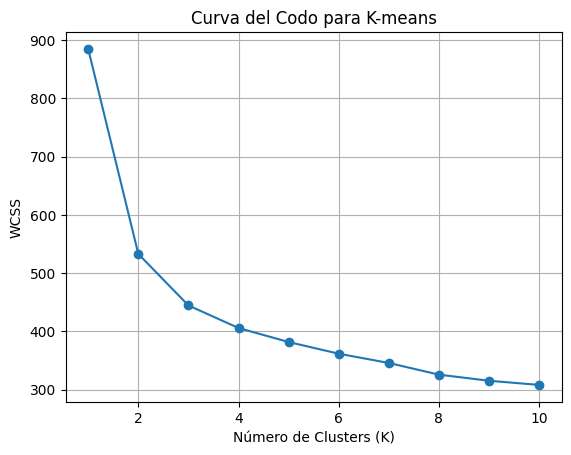

array([[0.23707665, 0.23079535, 0.01661574, 0.02330023, 0.17986589,
        0.1899669 , 0.07775231, 0.40930312, 0.25167643],
       [0.3844732 , 0.37132881, 0.06931608, 0.1025878 , 0.32902033,
        0.31156295, 0.2754159 , 0.1554734 , 0.25179708],
       [0.37481725, 0.36531433, 0.05530428, 0.08943257, 0.32931287,
        0.31012427, 0.28746345, 0.15222953, 0.55866228],
       [0.53926702, 0.50145433, 0.44502618, 0.49149215, 0.4904014 ,
        0.44386271, 0.5008726 , 0.09773124, 0.59976731],
       [0.55737044, 0.56039524, 0.06374773, 0.13316697, 0.51925791,
        0.47610405, 0.52792902, 0.06271426, 0.60859044]])

In [ ]:
from sklearn.cluster import KMeans

# Encuentra el valor óptimo de K utilizando la curva del codo
K_max = 10
inertia = []
clusters = []
for k in range(1, K_max+1):
    kmeans = KMeans(n_clusters=k,
                    random_state=seed, n_init='auto')
    kmeans.fit(X)
    clusters.append(kmeans)
    inertia.append(kmeans.inertia_)

# Grafica la curva del codo
plt.plot(range(1, K_max+1), inertia, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS')
plt.title('Curva del Codo para K-means')
plt.grid(True)
plt.show()
clusters[4].cluster_centers_ # Centroides reales y predichos

3.2.2 Comparacion etiqueta de cada ejemplo de entrenamiento con el cluster asignado ¿Es posible crear una relación entre ambas?

3.2.3 ¿A que cluster se le asignaría cada ejemplo del conjunto de test si se crea una relacion entre cluster y etiqueta? ¿Qué etiqueta asignarias a cada ejemplo de test?

3.2.4 Si tenemos etiquetas asociadas a los datos ¿Se puede utilizar clustering para hacer clasificación?